<a href="https://colab.research.google.com/github/JacopoMangiavacchi/FastLabeling/blob/master/pets_cats_dogs_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import FastAI and PETS dataset

In [1]:
!pip install fastai -U

     |████████████████████████████████| 358kB 2.7MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [8]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'
Path.BASE_PATH = path
path.ls()

(#7393) [Path('Bengal_191.jpg'),Path('pug_181.jpg'),Path('staffordshire_bull_terrier_92.jpg'),Path('saint_bernard_191.jpg'),Path('Ragdoll_163.jpg'),Path('samoyed_202.jpg'),Path('beagle_149.jpg'),Path('beagle_143.jpg'),Path('Russian_Blue_90.jpg'),Path('Egyptian_Mau_130.jpg')...]

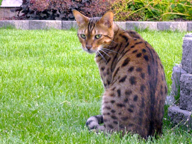

In [11]:
img = PILImage.create(path/'Bengal_191.jpg')
img.to_thumb(192)

# Prepare DataLoaders for PETS dataset

In [19]:
def is_cat(x): return x[0].isupper()

pets_dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

pets_dls.train_ds, pets_dls.valid_ds

((#5912) [(PILImage mode=RGB size=500x475, TensorCategory(0)),(PILImage mode=RGB size=500x375, TensorCategory(0)),(PILImage mode=RGB size=375x500, TensorCategory(0)),(PILImage mode=RGB size=333x500, TensorCategory(1)),(PILImage mode=RGB size=500x333, TensorCategory(1)),(PILImage mode=RGB size=500x333, TensorCategory(0)),(PILImage mode=RGB size=500x500, TensorCategory(1)),(PILImage mode=RGB size=500x375, TensorCategory(0)),(PILImage mode=RGB size=3264x2448, TensorCategory(1)),(PILImage mode=RGB size=500x451, TensorCategory(0))...],
 (#1478) [(PILImage mode=RGB size=450x313, TensorCategory(1)),(PILImage mode=RGB size=328x500, TensorCategory(1)),(PILImage mode=RGB size=500x347, TensorCategory(1)),(PILImage mode=RGB size=600x800, TensorCategory(1)),(PILImage mode=RGB size=473x500, TensorCategory(0)),(PILImage mode=RGB size=400x500, TensorCategory(1)),(PILImage mode=RGB size=500x333, TensorCategory(0)),(PILImage mode=RGB size=200x300, TensorCategory(0)),(PILImage mode=RGB size=334x500, Tens

In [25]:
pets_dls.vocab

(#2) [False,True]

# Train Full PETS Dataset on ResNet architecture with Cats and Dogs labels

In [28]:
learn = cnn_learner(pets_dls, resnet34, metrics=accuracy)
learn.fine_tune(3)


epoch,train_loss,valid_loss,accuracy,time
0,0.159285,0.012937,0.996617,00:44


epoch,train_loss,valid_loss,accuracy,time
0,0.067571,0.033731,0.991881,00:45
1,0.033298,0.009824,0.995264,00:45
2,0.013206,0.010531,0.995264,00:45


# Prepare DataLoaders for a small subset of the PETS Dataset with real breed labels for only xx samples per class (xx order of magnitute smaller)

# Transfer Learning reusing the ResNet model previosly trained on Cats / Dogs labels and change last Linear learner to fine-tune on the xx digit labels and train on the new small subset dataset

In [ ]:
learn.model[1][8]

Linear(in_features=512, out_features=2, bias=False)

In [ ]:
learn.model[1][8] = torch.nn.modules.linear.Linear(in_features=512, out_features=10, bias=False)

In [ ]:
learn2 = Learner(subset_dls, learn.model, metrics=accuracy)
learn2.fine_tune(20)


epoch,train_loss,valid_loss,accuracy,time
0,1.610765,1.880049,0.370000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.394862,0.651945,0.830000,00:01
1,0.295677,0.263021,0.930000,00:01
2,0.241495,0.183822,0.970000,00:01
3,0.196587,0.368697,0.930000,00:01
4,0.209737,0.249532,0.920000,00:01
5,0.212575,0.319085,0.920000,00:01
6,0.221468,1.296736,0.740000,00:01
7,0.227926,0.186414,0.950000,00:01
8,0.217985,0.402959,0.900000,00:01
9,0.196560,0.207718,0.950000,00:01


In [ ]:
test_path = (path/'testing'/'5').ls()[10]
test_image = Image.open(test_path)
test_image

In [ ]:
learn2.predict(test_path)

('5',
 tensor(5),
 tensor([1.2722e-04, 2.7529e-04, 1.6198e-04, 2.6956e-04, 1.3667e-04, 9.9791e-01,
         4.7790e-04, 9.5492e-05, 1.2841e-04, 4.1452e-04]))

# Classic Transfer Learning training from original ResNet on the new small subset dataset

In [ ]:
learn3 = cnn_learner(subset_dls, resnet34, metrics=accuracy)
learn3.fine_tune(20)

epoch,train_loss,valid_loss,accuracy,time
0,3.502641,2.090457,0.290000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,2.218468,1.978958,0.380000,00:01
1,1.966882,1.779201,0.490000,00:01
2,1.703303,1.500109,0.570000,00:01
3,1.465718,1.219936,0.650000,00:01
4,1.218771,1.098952,0.700000,00:01
5,1.008214,1.058523,0.710000,00:01
6,0.841556,0.933104,0.730000,00:01
7,0.692130,0.857036,0.750000,00:01
8,0.581191,0.802711,0.770000,00:01
9,0.486998,0.833801,0.770000,00:01


# Prepare DataLoaders for full MNIST dataset with original labels



In [ ]:
full_dls = ImageDataLoaders.from_folder(path, train='training', valid='testing')

full_dls.train_ds, full_dls.valid_ds


((#60000) [(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2))...],
 (#10000) [(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size=28x28, TensorCategory(2)),(PILImage mode=RGB size

# Benchmarking the two models with the full MNIST validation dataset

In [ ]:
learn2.validate(dl=full_dls.valid)

(#2) [0.09005868434906006,0.975600004196167]

In [ ]:
learn3.validate(dl=full_dls.valid)

(#2) [11.524850845336914,0.08940000087022781]